# Project Stage 3.1

# Importing the libraries

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import seaborn as sns

In [2]:
# Main recording path
recording_folder_path = './Respiratory_Sound_Database/audio_and_txt_files/'

In [3]:
# All recordings and annotations file paths
recording_paths = glob(recording_folder_path + '*.wav')
annotation_paths = glob(recording_folder_path + '*.txt')

In [4]:
# Getting all audios and sampling rates in a list
audio_list = []
sr_list = []
for path in recording_paths:
    audio, sr = librosa.load(path, sr=None, mono=False)
    audio_list.append(audio)
    sr_list.append(sr)

In [5]:
# The path of the labels
label_path = './Respiratory_Sound_Database/'

In [6]:
# Read labels data as pandas dataframe
label_csv = pd.read_csv(label_path + 'patient_diagnosis.csv')

In [7]:
# Zip patient IDs with the diseases in a dictionary mapping
label_dict = dict(zip(label_csv['ID'], label_csv['Disease']))

In [8]:
# Get the annotations data
annotation_data = pd.DataFrame(columns=['cycle_start', 'cycle_end', 'crackle', 'wheeze', 'rec_index'])

# For index, annotation path
for index, annot_path in enumerate(annotation_paths):
    
    # Separate path into a list ['ID', 'Index', 'ChestPos', 'SingleOrMultiChannel', 'Equipment']
    path_info = annot_path.split('\\')[-1][:-4].split('_')
    
    # Read annotations data 
    annot = pd.read_csv(annot_path, sep='\t', header=None, names=['cycle_start', 'cycle_end', 'crackle', 'wheeze'])
    
    # Recording index is equal to the current iteration index
    annot['rec_index'] = index
    
    # Sampling rate is taken from sr_list
    annot['sampling_rate'] = sr_list[index]
    
    # Equipment is the last component from path_info
    annot['equipment'] = path_info[-1]
    
    # Chest position is the middle component of the path_info
    annot['chest_pos'] = path_info[-3]
    
    # ID is the first component of the path_info
    rec_id = int(path_info[0])
    
    # Take label from the label dictionary
    label = label_dict[rec_id]
    
    # Disease is equal to the label extracted
    annot['disease'] = label
    
    # Append the constructed data to the total data
    annotation_data = annotation_data.append(annot, ignore_index=True)

In [9]:
# Calculate cycle duration by cycle_end - cycle_start
annotation_data['cycle_duration'] = annotation_data['cycle_end'] - annotation_data['cycle_start']

In [10]:
# Print the total annotations data
annotation_data

,cycle_start,cycle_end,crackle,wheeze,rec_index,sampling_rate,equipment,chest_pos,disease,cycle_duration
0,0.036,0.579,0,0,0,44100.0,Meditron,Al,URTI,0.543
1,0.579,2.450,0,0,0,44100.0,Meditron,Al,URTI,1.871
2,2.450,3.893,0,0,0,44100.0,Meditron,Al,URTI,1.443
3,3.893,5.793,0,0,0,44100.0,Meditron,Al,URTI,1.900
4,5.793,7.521,0,0,0,44100.0,Meditron,Al,URTI,1.728
...,...,...,...,...,...,...,...,...,...,...
6893,11.721,13.693,1,0,919,44100.0,LittC2SE,Pl,Pneumonia,1.972
6894,13.693,15.536,0,0,919,44100.0,LittC2SE,Pl,Pneumonia,1.843
6895,15.536,17.493,0,0,919,44100.0,LittC2SE,Pl,Pneumonia,1.957
6896,17.493,19.436,1,0,919,44100.0,LittC2SE,Pl,Pneumonia,1.943


There are total 6898 cycles in the dataset (confirmed from the source).

In [11]:
# Filter data where sampling rate is equal to 44100
filtered_data = annotation_data[annotation_data['sampling_rate'] == 44100]

In [12]:
# Reset index of the dataframe after the filtration
filtered_data.reset_index(drop=True, inplace=True)

In [13]:
# Clip the data within the range lower limit <= 
lower_limit = 1
filtered_data = filtered_data[filtered_data['cycle_duration'] >= lower_limit]

In [14]:
# Reset the index of the filtered data
filtered_data.reset_index(drop=True, inplace=True)

In [15]:
# Take the data filtered the 'AKGC417L' equipment
akgc_data = filtered_data[filtered_data.equipment == 'AKGC417L']
no_akgc_data = filtered_data[filtered_data.equipment != 'AKGC417L']

In [16]:
# Number of 'AKGC417L' samples to include in the original data
n_akgc_samples = int(np.ceil(no_akgc_data['disease'].value_counts().mean()))

In [17]:
# Sample X number of samples from the 'AKGC417L' data
akgc_sample_to_include = akgc_data.sample(n_akgc_samples)

In [18]:
# Get the new filtered data by concatenating no 'AKGC417L' microphone data with the sampled
filtered_data = pd.concat([no_akgc_data, akgc_sample_to_include], axis=0)

In [19]:
# New filtered data labels distribution
filtered_data['disease'].value_counts()

COPD              460
Healthy           292
Pneumonia         263
URTI              210
Bronchiolitis     132
Bronchiectasis    101
LRTI               10
Asthma              6
Name: disease, dtype: int64

In [20]:
# Reset the index of the dataframe
filtered_data.reset_index(drop=True, inplace=True)

In [21]:
filtered_data

,cycle_start,cycle_end,crackle,wheeze,rec_index,sampling_rate,equipment,chest_pos,disease,cycle_duration
0,0.579,2.450,0,0,0,44100.0,Meditron,Al,URTI,1.871
1,2.450,3.893,0,0,0,44100.0,Meditron,Al,URTI,1.443
2,3.893,5.793,0,0,0,44100.0,Meditron,Al,URTI,1.900
3,5.793,7.521,0,0,0,44100.0,Meditron,Al,URTI,1.728
4,7.521,9.279,0,0,0,44100.0,Meditron,Al,URTI,1.758
...,...,...,...,...,...,...,...,...,...,...
1469,17.571,19.975,0,0,515,44100.0,AKGC417L,Ar,COPD,2.404
1470,3.481,10.793,1,0,443,44100.0,AKGC417L,Tc,COPD,7.312
1471,4.911,7.375,0,0,185,44100.0,AKGC417L,Ar,COPD,2.464
1472,12.673,15.042,1,0,149,44100.0,AKGC417L,Lr,COPD,2.369


In [22]:
# Extract new cycles from the filtered data
new_cycles = []

# For observation in filtered data
for obs in range(len(filtered_data)):
    
    # Get the audio
    data = audio_list[filtered_data.loc[obs, "rec_index"]]
    
    # Get the sampling rate
    sr = sr_list[filtered_data.loc[obs, "rec_index"]]
    
    # Extract the cycle and update to new_cycles list
    new_cycles.append(data[int(sr*filtered_data.loc[obs, "cycle_start"]):int(np.ceil(sr*filtered_data.loc[obs, "cycle_end"]))])

In [23]:
min([len(x) for x in new_cycles])

44101

In [26]:
def fft_transform(sample, sr, n_freq=44100):
    """
    Does Fast Fourier Transformation on the given audio sample, sampling rate and number of frequencies.
    
    parameters:
    - sample: the audio sample
    - sr: the sampling rate
    - n_freq: number of frequencies to use for the fft
    
    returns:
    The frequencies and their respective amplitudes
    """
    # FFT using librosa
    fft_data = np.fft.fft(sample, n=n_freq)
    # The amplitudes of the fft are extracted by removing the imaginary numbers from the transformation by taking the abs(fft_data)
    amplitudes = np.abs(fft_data)
    # Getting the frequencies by uniformly sampling the number of frequencies
    freqs = np.fft.fftfreq(n_freq, 1/sr)
    
    return freqs[:len(freqs)//2], amplitudes[:len(amplitudes)//2]

In [27]:
def moving_average(data, window_size, stride):
    """
    Calculate the moving average of a sequence of data with a given window size and stride.

    Parameters:
    - data (list or numpy array): The input data.
    - window_size (int): The size of the moving average window.
    - stride (int): The stride, i.e., how many steps to move the window at each iteration.

    Returns:
    - list: A list containing the moving average values.
    """
    if window_size <= 0 or stride <= 0:
        raise ValueError("Window size and stride must be positive integers.")
    if window_size > len(data):
        raise ValueError("Window size cannot be larger than the data length.")

    moving_averages = []
    
    # Creating a pointer at index 0
    current_position = 0
    
    # While the pointer doesn't reach the end
    while current_position + window_size <= len(data):
        
        # Get the window from the data
        window = data[current_position:current_position + window_size]
        
        # Compute the average if the window
        average = sum(window) / window_size
        
        # Add the average to the list
        moving_averages.append(average)
        
        # Move the window by stride
        current_position += stride

    return moving_averages

In [28]:
# Get the FFT of each cycle
fft_cycles = np.array([fft_transform(cyc, sr=44100) for cyc in new_cycles])

In [29]:
# Multiply the magnitudes with their respective frequencies
fft_cycles = np.prod(fft_cycles, axis=1)

In [30]:
from scipy.stats import skew, kurtosis

In [31]:
def stat_extractor(measure):
    """
    Function for extracting statistics from the given frequency*amplitude measure.
    
    parameters:
    - measure: the 1d array of freq*ampl
    
    returns:
    - a list of 6 statistical measures extracted from the array
    
    """
    # The maximum of the array
    maximum = measure.max()
    
    # The index of the maximum of the array
    max_bin = np.argmax(measure)
    
    # The mean of the array
    mean = measure.mean()
    
    # The standard deviation of the array
    std = measure.std() 
    
    # The skewness of the array
    skewness = skew(measure)
    
    # The kurtosis of the array
    kurt = kurtosis(measure)
    
    return [mean, std, skewness, kurt, maximum, max_bin]

In [32]:
# For each FFT magnute x frequency calculate the statistics
fft_stats = [stat_extractor(m) for m in fft_cycles]

In [33]:
# Extract stats from the audio
audio_stats = [stat_extractor(cyc) for cyc in new_cycles]

In [34]:
# The dataframe for the statistics
audio_stats_data = pd.DataFrame(audio_stats, columns=['mean_aud', 'std_aud', 'skewness_aud', 'kurtosis_aud', 'max_aud', 'maxbin_aud'])
stats_data = pd.DataFrame(fft_stats, columns=['mean', 'std', 'skewness', 'kurtosis', 'max', 'maxbin'])

In [35]:
# Concatenate the annotations data with the statistics
merged_data = pd.concat([filtered_data, stats_data, audio_stats_data], axis=1)

In [36]:
# Drop the unnecessary columns
merged_data.drop(['cycle_start', 'cycle_end', 'rec_index', 'crackle', 'wheeze', 'sampling_rate'], axis=1, inplace=True)

In [37]:
# Take the final data except Asthma and LRTI
final_data = merged_data[(merged_data['disease'] != 'Asthma') & (merged_data['disease'] != 'LRTI')]

In [38]:
# Reset the indices of the data frame
final_data.reset_index(inplace=True, drop=True)

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [40]:
# Separate X and y and convert the target data to numeric values
X = final_data.drop(['disease'], axis=1)

# Get the target variable in y
y = final_data['disease']

# Convert the categorical labels to numeric
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [41]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [42]:
# One-hot encode the categorical variables
X_train = pd.get_dummies(X_train, columns=['equipment', 'chest_pos'])
X_test = pd.get_dummies(X_test, columns=['equipment', 'chest_pos'])

In [43]:
# Split the test data into validation
val_size = 0.3
val_n_obs = int(0.3*len(X_test))

In [44]:
# Split the X test data into validation and test
X_val = X_test[:val_n_obs]
X_test = X_test[val_n_obs:]

In [45]:
# Split the target test data into validation and test
y_val = y_test[:val_n_obs]
y_test = y_test[val_n_obs:]

In [47]:
print('X train shape =', X_train.shape)
print('X test shape =', X_test.shape)
print('X validation shape =', X_val.shape)

X train shape = (729, 23)
X test shape = (511, 23)
X validation shape = (218, 23)


In [48]:
# Instantiate the StandardScaler class
scaler = StandardScaler()

# Fit transform train data
X_train = scaler.fit_transform(X_train)

# And transform the test data
X_test = scaler.transform(X_test)

# And transform the validation data
X_val = scaler.transform(X_val)

In [49]:
# Define the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the dataset
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
# Predict train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [51]:
# Calculate the accuracy of train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)

Training accuracy: 1.0
Testing accuracy: 0.8317025440313112


In [52]:
import torch

C:\Users\hrayr\anaconda3\envs\acoustic\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
# Use GPU if available, else CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [54]:
# Convert numpy to torch, to float 32 and pass to GPU if available
X_train = torch.from_numpy(X_train).to(torch.float32).to(device)
X_test = torch.from_numpy(X_test).to(torch.float32).to(device)
X_val = torch.from_numpy(X_val).to(torch.float32).to(device)

In [55]:
# Convert numpy to torch, to int64 and pass to GPU if available
y_train = torch.from_numpy(y_train).long().to(device) 
y_test = torch.from_numpy(y_test).long().to(device) 
y_val = torch.from_numpy(y_val).long().to(device) 

In [57]:
def calc_loss(net, x, y):
    """
    Function for calculating the loss for predicting X and comparing with y
    
    Parameters:
    - net: The torch neural network
    - x: The X variable to predict
    - y: The target variable
    
    Returns:
    - The loss value
    """
    if net.training:       
        net.eval()
    loss_f = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        loss = loss_f(net(x), y).item() 
    return loss 

In [58]:
def trainer(net, x_train, x_val, y_train, y_val, break_count = 5, batch_size=64, epochs=1000, lr=0.0001):
    """
    A bit lazy to write the comments for this function and for torch operations, will do that for the final submission, sorry :)
    
    Trains the NN architecture on test set, evaluates on validation. If more than 5 times the validation loss rises, 
    the network saves its weights and the training process is terminated.
    
    """
    net.train()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    data_count = len(x_train)
    train_list = []
    val_list = []
    best_val_loss = 10**6
    previous_loss = 10**6
    count = break_count
    for epoch in range(1, epochs + 1):        
        trainloader = torch.utils.data.DataLoader(torch.arange(data_count), batch_size=batch_size, shuffle=True)
        running_loss = 0
        zeros_count = len(str(epochs)) - len(str(epoch))
        for i, batch_indxs in enumerate(trainloader, 0):

            train_data = x_train[batch_indxs]
            target_data = y_train[batch_indxs]
            prediction = net(train_data) 
            
            loss = torch.nn.CrossEntropyLoss()(prediction, target_data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
            percent = (i + 1) / len(trainloader) * 100
            print(f'\rEPOCH {"0" * zeros_count}{epoch}/{epochs} |', f'train loss = {loss.item():.7f} |', f'train accuracy = '
                  f'{calc_accuracy(net, train_data, target_data):.2f} |', f'{"=" * int(percent / 5)}> {percent:.2f}%', end='')
        
        val_loss = calc_loss(net, x_val, y_val)
        if count == 0: 
            torch.save(net.state_dict(), './weight_benchmark.pt')
            print("The validation loss started rising, terminating the training process...")
            break
        if best_val_loss >= val_loss:
            best_val_loss = val_loss
            
        if previous_loss >= val_loss:
            count = break_count
        else:
            count -= 1
        val_accuracy = calc_accuracy(net, x_val, y_val)
        
        train_list.append(loss.item())
        val_list.append(val_loss)
        previous_loss = val_loss

        print(f'\nAverage validation = {running_loss / len(trainloader):.6f}')
        print('Loss on validation =', round(val_loss, 8))
        print('Accuracy on validation =', round(val_accuracy, 4))
        print('-----------------------------------\n')
        
    plt.figure(figsize=(9,9))
    plt.plot(train_list)
    plt.plot(val_list)
    plt.legend(["trainloss", "valloss"], loc ="upper right")
    plt.show()

In [59]:
class NN(torch.nn.Module): 
    def __init__(self):
        super(NN, self).__init__()
        
        self.dense1 = torch.nn.Linear(23, 128)
        self.dense2 = torch.nn.Linear(128, 6) 
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)

        return x

In [60]:
def calc_accuracy(net, x, y):
    if net.training:       
        net.eval()
    with torch.no_grad(): 
        prediction = torch.nn.functional.softmax(net(x), -1).argmax(axis=1)
    accuracy = (prediction == y).sum().item()/len(y)
    return accuracy*100

In [61]:
net = NN().to(device)

EPOCH 0001/1000 | train loss = 1.8577888 | train accuracy = 10.11 | ====================> 100.00%
Average validation = 1.897147
Loss on validation = 1.88219011
Accuracy on validation = 8.7156
-----------------------------------

EPOCH 0002/1000 | train loss = 1.8270985 | train accuracy = 11.24 | ====================> 100.00%
Average validation = 1.847209
Loss on validation = 1.83236265
Accuracy on validation = 11.0092
-----------------------------------

EPOCH 0003/1000 | train loss = 1.7628616 | train accuracy = 16.85 | ====================> 100.00%
Average validation = 1.798451
Loss on validation = 1.78498471
Accuracy on validation = 17.4312
-----------------------------------

EPOCH 0004/1000 | train loss = 1.7401723 | train accuracy = 25.84 | ====================> 100.00%
Average validation = 1.754420
Loss on validation = 1.73963869
Accuracy on validation = 26.6055
-----------------------------------

EPOCH 0005/1000 | train loss = 1.6961650 | train accuracy = 26.97 | =============

EPOCH 0048/1000 | train loss = 0.8946294 | train accuracy = 59.55 | ====================> 100.00%
Average validation = 0.882515
Loss on validation = 0.93035018
Accuracy on validation = 61.4679
-----------------------------------

EPOCH 0049/1000 | train loss = 0.8331968 | train accuracy = 73.03 | ====================> 100.00%
Average validation = 0.871821
Loss on validation = 0.92302632
Accuracy on validation = 62.3853
-----------------------------------

EPOCH 0050/1000 | train loss = 0.8401341 | train accuracy = 70.79 | ====================> 100.00%
Average validation = 0.864854
Loss on validation = 0.9153024
Accuracy on validation = 63.3028
-----------------------------------

EPOCH 0051/1000 | train loss = 0.8503807 | train accuracy = 69.66 | ====================> 100.00%
Average validation = 0.858151
Loss on validation = 0.90794766
Accuracy on validation = 63.3028
-----------------------------------

EPOCH 0052/1000 | train loss = 0.8627083 | train accuracy = 70.79 | =============

EPOCH 0085/1000 | train loss = 0.6479820 | train accuracy = 77.53 | ====================> 100.00%
Average validation = 0.688056
Loss on validation = 0.74708062
Accuracy on validation = 71.1009
-----------------------------------

EPOCH 0086/1000 | train loss = 0.5977108 | train accuracy = 76.40 | ====================> 100.00%
Average validation = 0.682221
Loss on validation = 0.7438255
Accuracy on validation = 71.1009
-----------------------------------

EPOCH 0087/1000 | train loss = 0.6688157 | train accuracy = 77.53 | ====================> 100.00%
Average validation = 0.682709
Loss on validation = 0.74024963
Accuracy on validation = 71.5596
-----------------------------------

EPOCH 0088/1000 | train loss = 0.7218570 | train accuracy = 67.42 | ====================> 100.00%
Average validation = 0.682391
Loss on validation = 0.73687738
Accuracy on validation = 71.1009
-----------------------------------

EPOCH 0089/1000 | train loss = 0.7025597 | train accuracy = 71.91 | =============

EPOCH 0098/1000 | train loss = 0.6586965 | train accuracy = 75.28 | ====================> 100.00%
Average validation = 0.650415
Loss on validation = 0.70982695
Accuracy on validation = 72.4771
-----------------------------------

EPOCH 0099/1000 | train loss = 0.6873870 | train accuracy = 74.16 | ====================> 100.00%
Average validation = 0.649218
Loss on validation = 0.70689762
Accuracy on validation = 72.9358
-----------------------------------

EPOCH 0100/1000 | train loss = 0.6033725 | train accuracy = 79.78 | ====================> 100.00%
Average validation = 0.642554
Loss on validation = 0.7039668
Accuracy on validation = 73.3945
-----------------------------------

EPOCH 0101/1000 | train loss = 0.6020761 | train accuracy = 75.28 | ====================> 100.00%
Average validation = 0.639704
Loss on validation = 0.70149499
Accuracy on validation = 73.3945
-----------------------------------

EPOCH 0102/1000 | train loss = 0.6093047 | train accuracy = 78.65 | =============

EPOCH 0112/1000 | train loss = 0.6788711 | train accuracy = 71.91 | ====================> 100.00%
Average validation = 0.616703
Loss on validation = 0.6781581
Accuracy on validation = 72.9358
-----------------------------------

EPOCH 0113/1000 | train loss = 0.5244689 | train accuracy = 83.15 | ====================> 100.00%
Average validation = 0.606536
Loss on validation = 0.67586225
Accuracy on validation = 72.9358
-----------------------------------

EPOCH 0114/1000 | train loss = 0.5631676 | train accuracy = 79.78 | ====================> 100.00%
Average validation = 0.606321
Loss on validation = 0.67316222
Accuracy on validation = 73.3945
-----------------------------------

EPOCH 0115/1000 | train loss = 0.6235484 | train accuracy = 79.78 | ====================> 100.00%
Average validation = 0.607071
Loss on validation = 0.67139882
Accuracy on validation = 72.9358
-----------------------------------

EPOCH 0116/1000 | train loss = 0.6916465 | train accuracy = 75.28 | =============

EPOCH 0125/1000 | train loss = 0.4664576 | train accuracy = 91.01 | ====================> 100.00%
Average validation = 0.577325
Loss on validation = 0.65205729
Accuracy on validation = 73.8532
-----------------------------------

EPOCH 0126/1000 | train loss = 0.6129094 | train accuracy = 76.40 | ====================> 100.00%
Average validation = 0.582747
Loss on validation = 0.65030968
Accuracy on validation = 74.3119
-----------------------------------

EPOCH 0127/1000 | train loss = 0.5357586 | train accuracy = 82.02 | ====================> 100.00%
Average validation = 0.576760
Loss on validation = 0.64884812
Accuracy on validation = 74.3119
-----------------------------------

EPOCH 0128/1000 | train loss = 0.6289246 | train accuracy = 74.16 | ====================> 100.00%
Average validation = 0.579383
Loss on validation = 0.6469152
Accuracy on validation = 75.2294
-----------------------------------

EPOCH 0129/1000 | train loss = 0.5553742 | train accuracy = 79.78 | =============

EPOCH 0178/1000 | train loss = 0.4914195 | train accuracy = 88.76 | ====================> 100.00%
Average validation = 0.483900
Loss on validation = 0.57134473
Accuracy on validation = 79.8165
-----------------------------------

EPOCH 0179/1000 | train loss = 0.4867573 | train accuracy = 78.65 | ====================> 100.00%
Average validation = 0.481963
Loss on validation = 0.57087487
Accuracy on validation = 79.8165
-----------------------------------

EPOCH 0180/1000 | train loss = 0.4292445 | train accuracy = 92.13 | ====================> 100.00%
Average validation = 0.477603
Loss on validation = 0.56982458
Accuracy on validation = 79.8165
-----------------------------------

EPOCH 0181/1000 | train loss = 0.4647676 | train accuracy = 88.76 | ====================> 100.00%
Average validation = 0.477922
Loss on validation = 0.56791055
Accuracy on validation = 79.8165
-----------------------------------

EPOCH 0182/1000 | train loss = 0.4139117 | train accuracy = 87.64 | ============

EPOCH 0191/1000 | train loss = 0.4456392 | train accuracy = 86.52 | ====================> 100.00%
Average validation = 0.462555
Loss on validation = 0.55454189
Accuracy on validation = 79.8165
-----------------------------------

EPOCH 0192/1000 | train loss = 0.4125952 | train accuracy = 92.13 | ====================> 100.00%
Average validation = 0.459444
Loss on validation = 0.55322671
Accuracy on validation = 79.8165
-----------------------------------

EPOCH 0193/1000 | train loss = 0.4060940 | train accuracy = 85.39 | ====================> 100.00%
Average validation = 0.457614
Loss on validation = 0.55182225
Accuracy on validation = 79.8165
-----------------------------------

EPOCH 0194/1000 | train loss = 0.4318293 | train accuracy = 84.27 | ====================> 100.00%
Average validation = 0.457581
Loss on validation = 0.55047601
Accuracy on validation = 79.3578
-----------------------------------

EPOCH 0195/1000 | train loss = 0.4828764 | train accuracy = 86.52 | ============

EPOCH 0205/1000 | train loss = 0.4961703 | train accuracy = 83.15 | ====================> 100.00%
Average validation = 0.445808
Loss on validation = 0.53811914
Accuracy on validation = 81.6514
-----------------------------------

EPOCH 0206/1000 | train loss = 0.4689905 | train accuracy = 86.52 | ====================> 100.00%
Average validation = 0.443065
Loss on validation = 0.53681749
Accuracy on validation = 81.6514
-----------------------------------

EPOCH 0207/1000 | train loss = 0.4625831 | train accuracy = 80.90 | ====================> 100.00%
Average validation = 0.441484
Loss on validation = 0.53576171
Accuracy on validation = 82.1101
-----------------------------------

EPOCH 0208/1000 | train loss = 0.4606399 | train accuracy = 87.64 | ====================> 100.00%
Average validation = 0.439928
Loss on validation = 0.53495473
Accuracy on validation = 81.6514
-----------------------------------

EPOCH 0209/1000 | train loss = 0.4629960 | train accuracy = 92.13 | ============

EPOCH 0218/1000 | train loss = 0.5236045 | train accuracy = 79.78 | ====================> 100.00%
Average validation = 0.430559
Loss on validation = 0.52384663
Accuracy on validation = 83.0275
-----------------------------------

EPOCH 0219/1000 | train loss = 0.3818379 | train accuracy = 91.01 | ====================> 100.00%
Average validation = 0.422268
Loss on validation = 0.52294278
Accuracy on validation = 82.5688
-----------------------------------

EPOCH 0220/1000 | train loss = 0.4588179 | train accuracy = 84.27 | ====================> 100.00%
Average validation = 0.424728
Loss on validation = 0.5211665
Accuracy on validation = 83.0275
-----------------------------------

EPOCH 0221/1000 | train loss = 0.4196133 | train accuracy = 85.39 | ====================> 100.00%
Average validation = 0.421674
Loss on validation = 0.51972586
Accuracy on validation = 83.0275
-----------------------------------

EPOCH 0222/1000 | train loss = 0.4108866 | train accuracy = 91.01 | =============

EPOCH 0231/1000 | train loss = 0.4497111 | train accuracy = 84.27 | ====================> 100.00%
Average validation = 0.411109
Loss on validation = 0.50942963
Accuracy on validation = 82.5688
-----------------------------------

EPOCH 0232/1000 | train loss = 0.3600602 | train accuracy = 93.26 | ====================> 100.00%
Average validation = 0.405393
Loss on validation = 0.50871623
Accuracy on validation = 82.5688
-----------------------------------

EPOCH 0233/1000 | train loss = 0.3849652 | train accuracy = 88.76 | ====================> 100.00%
Average validation = 0.405412
Loss on validation = 0.50797963
Accuracy on validation = 82.5688
-----------------------------------

EPOCH 0234/1000 | train loss = 0.4274271 | train accuracy = 85.39 | ====================> 100.00%
Average validation = 0.406492
Loss on validation = 0.5068537
Accuracy on validation = 82.5688
-----------------------------------

EPOCH 0235/1000 | train loss = 0.3837277 | train accuracy = 88.76 | =============

EPOCH 0302/1000 | train loss = 0.4281690 | train accuracy = 87.64 | ====================> 100.00%
Average validation = 0.337882
Loss on validation = 0.44301111
Accuracy on validation = 84.8624
-----------------------------------

EPOCH 0303/1000 | train loss = 0.3254138 | train accuracy = 92.13 | ====================> 100.00%
Average validation = 0.331954
Loss on validation = 0.44140926
Accuracy on validation = 84.8624
-----------------------------------

EPOCH 0304/1000 | train loss = 0.3267483 | train accuracy = 91.01 | ====================> 100.00%
Average validation = 0.331199
Loss on validation = 0.44030693
Accuracy on validation = 84.8624
-----------------------------------

EPOCH 0305/1000 | train loss = 0.3326283 | train accuracy = 92.13 | ====================> 100.00%
Average validation = 0.330495
Loss on validation = 0.43961433
Accuracy on validation = 84.8624
-----------------------------------

EPOCH 0306/1000 | train loss = 0.4449280 | train accuracy = 83.15 | ============

EPOCH 0315/1000 | train loss = 0.3908130 | train accuracy = 86.52 | ====================> 100.00%
Average validation = 0.325002
Loss on validation = 0.43321505
Accuracy on validation = 85.3211
-----------------------------------

EPOCH 0316/1000 | train loss = 0.3422512 | train accuracy = 92.13 | ====================> 100.00%
Average validation = 0.321615
Loss on validation = 0.43246084
Accuracy on validation = 85.3211
-----------------------------------

EPOCH 0317/1000 | train loss = 0.3215044 | train accuracy = 88.76 | ====================> 100.00%
Average validation = 0.319721
Loss on validation = 0.43164408
Accuracy on validation = 85.3211
-----------------------------------

EPOCH 0318/1000 | train loss = 0.3540951 | train accuracy = 88.76 | ====================> 100.00%
Average validation = 0.320602
Loss on validation = 0.43050528
Accuracy on validation = 85.3211
-----------------------------------

EPOCH 0319/1000 | train loss = 0.3723067 | train accuracy = 88.76 | ============

EPOCH 0329/1000 | train loss = 0.2854957 | train accuracy = 92.13 | ====================> 100.00%
Average validation = 0.308295
Loss on validation = 0.42130518
Accuracy on validation = 85.3211
-----------------------------------

EPOCH 0330/1000 | train loss = 0.3388059 | train accuracy = 88.76 | ====================> 100.00%
Average validation = 0.310092
Loss on validation = 0.42066801
Accuracy on validation = 85.7798
-----------------------------------

EPOCH 0331/1000 | train loss = 0.3195704 | train accuracy = 93.26 | ====================> 100.00%
Average validation = 0.308290
Loss on validation = 0.41989458
Accuracy on validation = 85.7798
-----------------------------------

EPOCH 0332/1000 | train loss = 0.3376673 | train accuracy = 89.89 | ====================> 100.00%
Average validation = 0.308378
Loss on validation = 0.41931137
Accuracy on validation = 85.7798
-----------------------------------

EPOCH 0333/1000 | train loss = 0.2838985 | train accuracy = 92.13 | ============

EPOCH 0378/1000 | train loss = 0.2768464 | train accuracy = 93.26 | ====================> 100.00%
Average validation = 0.272229
Loss on validation = 0.39014542
Accuracy on validation = 86.2385
-----------------------------------

EPOCH 0379/1000 | train loss = 0.2875954 | train accuracy = 91.01 | ====================> 100.00%
Average validation = 0.272096
Loss on validation = 0.38951233
Accuracy on validation = 86.6972
-----------------------------------

EPOCH 0380/1000 | train loss = 0.2412242 | train accuracy = 95.51 | ====================> 100.00%
Average validation = 0.269039
Loss on validation = 0.38849294
Accuracy on validation = 86.6972
-----------------------------------

EPOCH 0381/1000 | train loss = 0.2852542 | train accuracy = 92.13 | ====================> 100.00%
Average validation = 0.270703
Loss on validation = 0.38804385
Accuracy on validation = 86.6972
-----------------------------------

EPOCH 0382/1000 | train loss = 0.1952062 | train accuracy = 96.63 | ============

EPOCH 0419/1000 | train loss = 0.2523224 | train accuracy = 94.38 | ====================> 100.00%
Average validation = 0.245701
Loss on validation = 0.37099376
Accuracy on validation = 85.3211
-----------------------------------

EPOCH 0420/1000 | train loss = 0.1776397 | train accuracy = 96.63 | ====================> 100.00%
Average validation = 0.241415
Loss on validation = 0.36986801
Accuracy on validation = 85.3211
-----------------------------------

EPOCH 0421/1000 | train loss = 0.2479241 | train accuracy = 93.26 | ====================> 100.00%
Average validation = 0.244374
Loss on validation = 0.3693302
Accuracy on validation = 85.3211
-----------------------------------

EPOCH 0422/1000 | train loss = 0.2062778 | train accuracy = 96.63 | ====================> 100.00%
Average validation = 0.241895
Loss on validation = 0.36951539
Accuracy on validation = 85.3211
-----------------------------------

EPOCH 0423/1000 | train loss = 0.2007015 | train accuracy = 93.26 | =============

EPOCH 0432/1000 | train loss = 0.2207373 | train accuracy = 96.63 | ====================> 100.00%
Average validation = 0.236902
Loss on validation = 0.36482236
Accuracy on validation = 85.3211
-----------------------------------

EPOCH 0433/1000 | train loss = 0.2715424 | train accuracy = 91.01 | ====================> 100.00%
Average validation = 0.238909
Loss on validation = 0.36454591
Accuracy on validation = 85.7798
-----------------------------------

EPOCH 0434/1000 | train loss = 0.2256028 | train accuracy = 93.26 | ====================> 100.00%
Average validation = 0.236033
Loss on validation = 0.3641381
Accuracy on validation = 85.3211
-----------------------------------

EPOCH 0435/1000 | train loss = 0.2164021 | train accuracy = 94.38 | ====================> 100.00%
Average validation = 0.235171
Loss on validation = 0.36339071
Accuracy on validation = 85.3211
-----------------------------------

EPOCH 0436/1000 | train loss = 0.1611484 | train accuracy = 97.75 | =============

EPOCH 0468/1000 | train loss = 0.2678868 | train accuracy = 93.26 | ====================> 100.00%
Average validation = 0.220757
Loss on validation = 0.35061267
Accuracy on validation = 85.7798
-----------------------------------

EPOCH 0469/1000 | train loss = 0.2095754 | train accuracy = 92.13 | ====================> 100.00%
Average validation = 0.217333
Loss on validation = 0.35041967
Accuracy on validation = 85.7798
-----------------------------------

EPOCH 0470/1000 | train loss = 0.1765483 | train accuracy = 96.63 | ====================> 100.00%
Average validation = 0.215303
Loss on validation = 0.34948546
Accuracy on validation = 85.7798
-----------------------------------

EPOCH 0471/1000 | train loss = 0.2405725 | train accuracy = 93.26 | ====================> 100.00%
Average validation = 0.217938
Loss on validation = 0.34910408
Accuracy on validation = 85.7798
-----------------------------------

EPOCH 0472/1000 | train loss = 0.2060528 | train accuracy = 93.26 | ============

EPOCH 0481/1000 | train loss = 0.2411076 | train accuracy = 94.38 | ====================> 100.00%
Average validation = 0.213187
Loss on validation = 0.34651449
Accuracy on validation = 86.6972
-----------------------------------

EPOCH 0482/1000 | train loss = 0.2642015 | train accuracy = 92.13 | ====================> 100.00%
Average validation = 0.213737
Loss on validation = 0.34564817
Accuracy on validation = 86.6972
-----------------------------------

EPOCH 0483/1000 | train loss = 0.2133054 | train accuracy = 94.38 | ====================> 100.00%
Average validation = 0.210730
Loss on validation = 0.34457329
Accuracy on validation = 87.6147
-----------------------------------

EPOCH 0484/1000 | train loss = 0.2253579 | train accuracy = 95.51 | ====================> 100.00%
Average validation = 0.211031
Loss on validation = 0.34466842
Accuracy on validation = 87.156
-----------------------------------

EPOCH 0485/1000 | train loss = 0.2332692 | train accuracy = 93.26 | =============

EPOCH 0520/1000 | train loss = 0.1951516 | train accuracy = 96.63 | ====================> 100.00%
Average validation = 0.193626
Loss on validation = 0.33133292
Accuracy on validation = 88.0734
-----------------------------------

EPOCH 0521/1000 | train loss = 0.1900688 | train accuracy = 97.75 | ====================> 100.00%
Average validation = 0.192885
Loss on validation = 0.33137399
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0522/1000 | train loss = 0.2212806 | train accuracy = 95.51 | ====================> 100.00%
Average validation = 0.194044
Loss on validation = 0.33077696
Accuracy on validation = 87.6147
-----------------------------------

EPOCH 0523/1000 | train loss = 0.2361259 | train accuracy = 95.51 | ====================> 100.00%
Average validation = 0.194372
Loss on validation = 0.33085525
Accuracy on validation = 87.6147
-----------------------------------

EPOCH 0524/1000 | train loss = 0.1591653 | train accuracy = 96.63 | ============

EPOCH 0566/1000 | train loss = 0.1808708 | train accuracy = 97.75 | ====================> 100.00%
Average validation = 0.175069
Loss on validation = 0.31993958
Accuracy on validation = 88.9908
-----------------------------------

EPOCH 0567/1000 | train loss = 0.2139429 | train accuracy = 96.63 | ====================> 100.00%
Average validation = 0.176524
Loss on validation = 0.31837061
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0568/1000 | train loss = 0.2000124 | train accuracy = 92.13 | ====================> 100.00%
Average validation = 0.175306
Loss on validation = 0.31781814
Accuracy on validation = 88.9908
-----------------------------------

EPOCH 0569/1000 | train loss = 0.1984709 | train accuracy = 94.38 | ====================> 100.00%
Average validation = 0.174788
Loss on validation = 0.31782207
Accuracy on validation = 88.9908
-----------------------------------

EPOCH 0570/1000 | train loss = 0.1623086 | train accuracy = 96.63 | ============

EPOCH 0579/1000 | train loss = 0.1518221 | train accuracy = 97.75 | ====================> 100.00%
Average validation = 0.169090
Loss on validation = 0.31779227
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0580/1000 | train loss = 0.1591682 | train accuracy = 95.51 | ====================> 100.00%
Average validation = 0.169007
Loss on validation = 0.31705648
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0581/1000 | train loss = 0.1797040 | train accuracy = 95.51 | ====================> 100.00%
Average validation = 0.169605
Loss on validation = 0.31712282
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0582/1000 | train loss = 0.2149973 | train accuracy = 95.51 | ====================> 100.00%
Average validation = 0.171112
Loss on validation = 0.31677029
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0583/1000 | train loss = 0.1560118 | train accuracy = 98.88 | ============

EPOCH 0616/1000 | train loss = 0.1140339 | train accuracy = 100.00 | ====================> 100.00%
Average validation = 0.154652
Loss on validation = 0.30919811
Accuracy on validation = 88.9908
-----------------------------------

EPOCH 0617/1000 | train loss = 0.1741739 | train accuracy = 97.75 | ====================> 100.00%
Average validation = 0.157511
Loss on validation = 0.30886969
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0618/1000 | train loss = 0.1513650 | train accuracy = 97.75 | ====================> 100.00%
Average validation = 0.155969
Loss on validation = 0.30908772
Accuracy on validation = 88.0734
-----------------------------------

EPOCH 0619/1000 | train loss = 0.1254617 | train accuracy = 96.63 | ====================> 100.00%
Average validation = 0.154170
Loss on validation = 0.30883506
Accuracy on validation = 88.0734
-----------------------------------

EPOCH 0620/1000 | train loss = 0.1569620 | train accuracy = 96.63 | ===========

EPOCH 0630/1000 | train loss = 0.1142438 | train accuracy = 97.75 | ====================> 100.00%
Average validation = 0.150187
Loss on validation = 0.30636829
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0631/1000 | train loss = 0.1536097 | train accuracy = 96.63 | ====================> 100.00%
Average validation = 0.151938
Loss on validation = 0.30640867
Accuracy on validation = 88.0734
-----------------------------------

EPOCH 0632/1000 | train loss = 0.1530315 | train accuracy = 96.63 | ====================> 100.00%
Average validation = 0.151646
Loss on validation = 0.30542502
Accuracy on validation = 88.0734
-----------------------------------

EPOCH 0633/1000 | train loss = 0.1580120 | train accuracy = 96.63 | ====================> 100.00%
Average validation = 0.151681
Loss on validation = 0.30525541
Accuracy on validation = 87.6147
-----------------------------------

EPOCH 0634/1000 | train loss = 0.1362980 | train accuracy = 97.75 | ============

EPOCH 0643/1000 | train loss = 0.1528409 | train accuracy = 97.75 | ====================> 100.00%
Average validation = 0.148142
Loss on validation = 0.30311826
Accuracy on validation = 87.6147
-----------------------------------

EPOCH 0644/1000 | train loss = 0.1305491 | train accuracy = 96.63 | ====================> 100.00%
Average validation = 0.146736
Loss on validation = 0.30302703
Accuracy on validation = 87.6147
-----------------------------------

EPOCH 0645/1000 | train loss = 0.1459122 | train accuracy = 97.75 | ====================> 100.00%
Average validation = 0.147296
Loss on validation = 0.30204645
Accuracy on validation = 88.0734
-----------------------------------

EPOCH 0646/1000 | train loss = 0.1310423 | train accuracy = 98.88 | ====================> 100.00%
Average validation = 0.146164
Loss on validation = 0.30269024
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0647/1000 | train loss = 0.1729669 | train accuracy = 97.75 | ============

EPOCH 0689/1000 | train loss = 0.1500100 | train accuracy = 96.63 | ====================> 100.00%
Average validation = 0.135161
Loss on validation = 0.29858074
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0690/1000 | train loss = 0.1455842 | train accuracy = 94.38 | ====================> 100.00%
Average validation = 0.134608
Loss on validation = 0.29842758
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0691/1000 | train loss = 0.0964154 | train accuracy = 98.88 | ====================> 100.00%
Average validation = 0.131865
Loss on validation = 0.29750872
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0692/1000 | train loss = 0.1004368 | train accuracy = 100.00 | ====================> 100.00%
Average validation = 0.131766
Loss on validation = 0.29825407
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0693/1000 | train loss = 0.1497230 | train accuracy = 97.75 | ===========

EPOCH 0733/1000 | train loss = 0.1209274 | train accuracy = 96.63 | ====================> 100.00%
Average validation = 0.122716
Loss on validation = 0.29334518
Accuracy on validation = 88.9908
-----------------------------------

EPOCH 0734/1000 | train loss = 0.1223265 | train accuracy = 97.75 | ====================> 100.00%
Average validation = 0.122621
Loss on validation = 0.29216138
Accuracy on validation = 88.9908
-----------------------------------

EPOCH 0735/1000 | train loss = 0.1187480 | train accuracy = 96.63 | ====================> 100.00%
Average validation = 0.122024
Loss on validation = 0.29393131
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0736/1000 | train loss = 0.1409922 | train accuracy = 98.88 | ====================> 100.00%
Average validation = 0.122981
Loss on validation = 0.29444817
Accuracy on validation = 88.5321
-----------------------------------

EPOCH 0737/1000 | train loss = 0.1134349 | train accuracy = 98.88 | ============

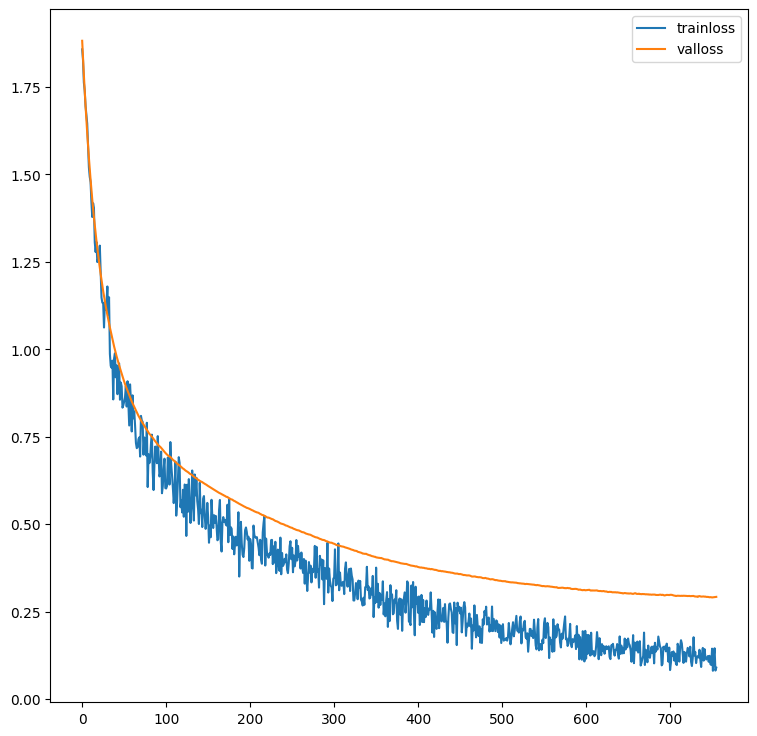

In [62]:
trainer(net, X_train, X_val, y_train, y_val, batch_size=128, epochs=1000, lr=0.0003)

In [63]:
# Calculate the test accuracy
test_accuracy = calc_accuracy(net, X_test, y_test)

In [64]:
print('Test accuracy =', test_accuracy)

Test accuracy = 83.36594911937377


In [161]:
from sklearn.metrics import confusion_matrix

In [167]:
def calculate_metrics(y_true, y_pred):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]

    # Initialize arrays to store precision, recall, and F1 score for each class
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    # Calculate metrics for each class
    for i in range(num_classes):
        true_positives = cm[i, i]
        false_positives = np.sum(cm[:, i]) - true_positives
        false_negatives = np.sum(cm[i, :]) - true_positives

        # Calculate precision, recall, and F1 score, handling division by zero
        precision[i] = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
        recall[i] = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0

    # Optionally, you can calculate macro averages for each metric
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1_score)

    return cm, precision, recall, f1_score, macro_precision, macro_recall, macro_f1

In [168]:
cm, _, _, _, precision, recall, f1 = calculate_metrics(y_test.cpu().detach().numpy(), test_prediction.cpu().detach().numpy())

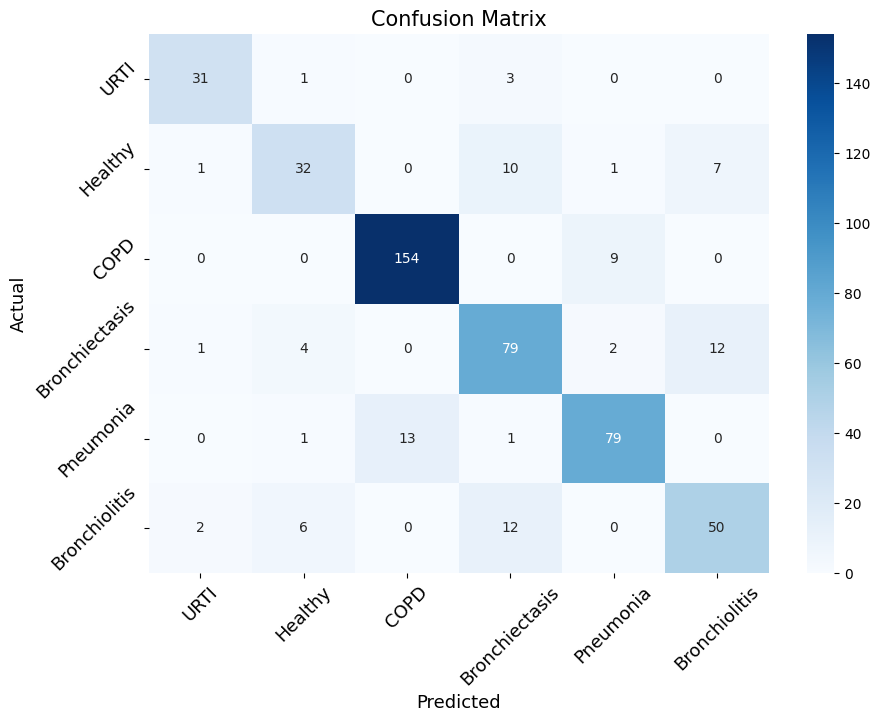

In [187]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=targets, yticklabels=targets)
plt.ylabel('Actual',size=13)
plt.xlabel('Predicted',size=13)
plt.yticks(rotation=45, size=13)
plt.xticks(rotation=45, size=13)
plt.title('Confusion Matrix',size=15)
plt.show()

In [189]:
print(f'Macro recall on test data = {recall}')
print(f'Macro precision on test data = {precision}')
print(f'Macro f1-score on test data = {f1}')

print(f'Accuracy on test data = {f1}')

Macro recall on test data = 0.8031307062267103
Macro precision on test data = 0.8133822005470014
Macro f1-score on test data = 0.8074225778687255
